# Market Basket Analysis

LSESU Data Science Society Project

In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


df_csv = pd.read_csv("online_retail.csv", encoding="unicode_escape") #import data from csv file
df_csv.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2010 08:26,3.39,17850.0,United Kingdom


## Cleaning the Data

In [51]:
df_csv.columns = df_csv.columns.str.lower().str.strip()
df_csv.columns

Index(['invoice', 'stockcode', 'description', 'quantity', 'invoicedate',
       'price', 'customer id', 'country'],
      dtype='object')

In [52]:
df_csv.isnull().sum() #check null values

invoice             0
stockcode           0
description      1454
quantity            0
invoicedate         0
price               0
customer id    135080
country             0
dtype: int64

In [53]:
df_csv.shape

(541910, 8)

total rows 541910

In [54]:
df_csv.dtypes #check columns type

invoice         object
stockcode       object
description     object
quantity         int64
invoicedate     object
price          float64
customer id    float64
country         object
dtype: object

In [55]:
df_csv["invoicedate"] = pd.to_datetime(df_csv["invoicedate"], format="%d/%m/%Y %H:%M")
df_csv.dtypes

invoice                object
stockcode              object
description            object
quantity                int64
invoicedate    datetime64[ns]
price                 float64
customer id           float64
country                object
dtype: object

In [56]:
df_csv = df_csv[df_csv["description"].notna()]
df_csv = df_csv[df_csv["quantity"] > 0]
df_csv = df_csv[df_csv["price"]> 0]
df_csv = df_csv[df_csv["country"] == "United Kingdom"]
df_csv.describe()

,quantity,price,customer id
count,485123.000000,485123.000000,354321.000000
mean,9.610738,3.849679,15552.486392
std,161.904143,34.677371,1594.527150
min,1.000000,0.001000,12346.000000
25%,1.000000,1.250000,14194.000000
50%,3.000000,2.100000,15522.000000
75%,10.000000,4.130000,16931.000000
max,80995.000000,13541.330000,18287.000000


1. Exclude price below 0
2. Exclude quantity below 0 
3. Exclude NULL descriptions

In [57]:
df_csv["description"] = df_csv["description"].str.strip()
df_csv["invoice"] = df_csv["invoice"].astype("str")
df_csv["stockcode"] = df_csv["stockcode"].astype("str")
df_csv.head()

,invoice,stockcode,description,quantity,invoicedate,price,customer id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [58]:
len(df_csv["description"].unique())

3996

In [59]:
df_csv[df_csv["description"].str.contains("METAL LANTERN")]

,invoice,stockcode,description,quantity,invoicedate,price,customer id,country
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
50,536373,71053,WHITE METAL LANTERN,6,2010-12-01 09:02:00,3.39,17850.0,United Kingdom
67,536375,71053,WHITE METAL LANTERN,6,2010-12-01 09:32:00,3.39,17850.0,United Kingdom
281,536396,71053,WHITE METAL LANTERN,6,2010-12-01 10:51:00,3.39,17850.0,United Kingdom
417,536406,71053,WHITE METAL LANTERN,8,2010-12-01 11:33:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
534552,581149,71053,WHITE MOROCCAN METAL LANTERN,1,2011-12-07 14:12:00,3.75,15471.0,United Kingdom
534553,581149,71053,WHITE MOROCCAN METAL LANTERN,1,2011-12-07 14:12:00,3.75,15471.0,United Kingdom
536736,581219,71053,WHITE MOROCCAN METAL LANTERN,1,2011-12-08 09:28:00,8.29,NaN,United Kingdom
539298,581439,71053,WHITE MOROCCAN METAL LANTERN,1,2011-12-08 16:30:00,8.29,NaN,United Kingdom


Desctiptions might not be consistent across the same product - one evidence is shown above. Hence, Asssociation Rule Analysis made based on stockcode might be more desirable.

<AxesSubplot:>

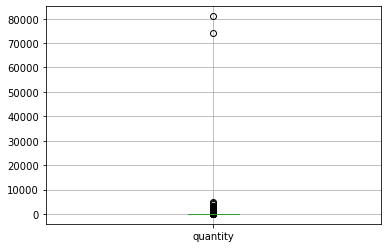

In [60]:
quantity_big = df_csv[df_csv["quantity"] > 10]
quantity_big.boxplot(column = ["quantity"])

In [61]:
bigger= quantity_big[quantity_big["quantity"] > 1000]
bigger

,invoice,stockcode,description,quantity,invoicedate,price,customer id,country
4850,536809,84950,ASSORTED COLOUR T-LIGHT HOLDER,1824,2010-12-02 16:48:00,0.55,15299.0,United Kingdom
4945,536830,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,2880,2010-12-02 17:38:00,0.18,16754.0,United Kingdom
4946,536830,21915,RED HARMONICA IN BOX,1400,2010-12-02 17:38:00,1.06,16754.0,United Kingdom
16435,537659,22189,CREAM HEART CARD HOLDER,1008,2010-12-07 16:43:00,2.31,18102.0,United Kingdom
16436,537659,22188,BLACK HEART CARD HOLDER,1008,2010-12-07 16:43:00,2.31,18102.0,United Kingdom
...,...,...,...,...,...,...,...,...
521375,580363,23582,VINTAGE DOILY JUMBO BAG RED,1500,2011-12-02 16:32:00,1.79,13868.0,United Kingdom
533812,581115,22413,METAL SIGN TAKE IT OR LEAVE IT,1404,2011-12-07 12:20:00,2.75,15195.0,United Kingdom
540070,581458,22197,POPCORN HOLDER,1500,2011-12-08 18:45:00,0.72,17949.0,United Kingdom
540071,581459,22197,POPCORN HOLDER,1200,2011-12-08 18:46:00,0.72,17949.0,United Kingdom


In [62]:
print(quantity_big[quantity_big["invoice"]=="581458"]["description"])
print(quantity_big[quantity_big["invoice"]=="581115"]["description"])
print(len(bigger["invoice"].unique()))

540070    POPCORN HOLDER
Name: description, dtype: object
533812    METAL SIGN TAKE IT OR LEAVE IT
Name: description, dtype: object
75


I suspect a transaction with a very high product quantity might come from a B2B business. A normal customer like you and I will not probably buy a product more than _a certain number_. We can do a rigorous statistical analysis to find _this number_ and then filter out those above it. We would be left with invoice of B2C transactions.

Most B2B transactions will only have one item in their shopping cart. 

Just realised that this based on the UCI website, the customers are mostly wholesalers.

<AxesSubplot:>

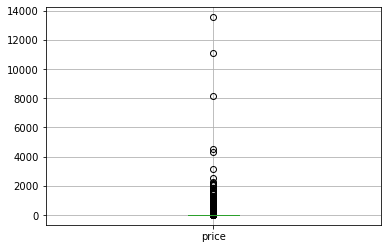

In [63]:
df_csv.boxplot(column = ["price"])

In [64]:
df_csv[df_csv["price"]>2000]

,invoice,stockcode,description,quantity,invoicedate,price,customer id,country
15017,537632,AMAZONFEE,AMAZON FEE,1,2010-12-07 15:08:00,13541.33,NaN,United Kingdom
173382,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029.0,United Kingdom
268028,560373,M,Manual,1,2011-07-18 12:30:00,4287.63,NaN,United Kingdom
297438,562946,M,Manual,1,2011-08-11 09:38:00,2500.00,15581.0,United Kingdom
297725,562955,DOT,DOTCOM POSTAGE,1,2011-08-11 10:14:00,4505.17,NaN,United Kingdom
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,NaN,United Kingdom
342997,566927,M,Manual,1,2011-09-15 15:20:00,2033.10,17846.0,United Kingdom
374541,569382,M,Manual,1,2011-10-03 16:44:00,3155.95,15502.0,United Kingdom
431348,573585,DOT,DOTCOM POSTAGE,1,2011-10-31 14:41:00,2019.05,NaN,United Kingdom
493021,578149,DOT,DOTCOM POSTAGE,1,2011-11-23 11:11:00,2275.54,NaN,United Kingdom


the file does include some weird transactions. some are displayed above.So not all stockcode represent products as shown above.

In [68]:
df_csv[df_csv["invoice"] == "562946"]

,invoice,stockcode,description,quantity,invoicedate,price,customer id,country
297438,562946,M,Manual,1,2011-08-11 09:38:00,2500.0,15581.0,United Kingdom


1. It's ok for the quantity for a product to be high becausse it's a B2B busineess Confirm this with teamates.
2. Need to firgure out a clever way to differentiate between actual product transactions and non product transactions. 
3. Might need to think about segmenting the customers (business and actual customer)
4. Need to firgure out that max price of a product. then exclude all transactions will price higher than this. cant just take from third quartile cus the price look so cheap for the most expensive products.

In [73]:
df_csv[df_csv["stockcode"] !=  "DOT"]
df_csv[df_csv["stockcode"] !=  "M"]
df_csv[df_csv["stockcode"] !=  "B"]
df_csv[df_csv["stockcode"] !=  "POST"]
df_csv[df_csv["stockcode"] !=  "AMAZONFEE"]

,invoice,stockcode,description,quantity,invoicedate,price,customer id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541889,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2011-12-09 12:31:00,1.95,15804.0,United Kingdom
541890,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2.95,13113.0,United Kingdom
541891,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2011-12-09 12:49:00,1.25,13113.0,United Kingdom
541892,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,2011-12-09 12:49:00,8.95,13113.0,United Kingdom


In [72]:
df_csv["stockcode"] = df_csv["stockcode"].str.strip()

In [74]:
df_csv[df_csv["price"]>1000]

,invoice,stockcode,description,quantity,invoicedate,price,customer id,country
15017,537632,AMAZONFEE,AMAZON FEE,1,2010-12-07 15:08:00,13541.33,NaN,United Kingdom
41448,539856,M,Manual,1,2010-12-22 14:41:00,1298.40,NaN,United Kingdom
150615,549468,M,Manual,1,2011-04-08 14:27:00,1867.86,17940.0,United Kingdom
173382,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029.0,United Kingdom
268028,560373,M,Manual,1,2011-07-18 12:30:00,4287.63,NaN,United Kingdom
268432,560421,M,Manual,1,2011-07-18 15:13:00,1592.49,NaN,United Kingdom
297438,562946,M,Manual,1,2011-08-11 09:38:00,2500.00,15581.0,United Kingdom
297725,562955,DOT,DOTCOM POSTAGE,1,2011-08-11 10:14:00,4505.17,NaN,United Kingdom
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,NaN,United Kingdom
303524,563549,DOT,DOTCOM POSTAGE,1,2011-08-17 12:34:00,1154.67,NaN,United Kingdom


In [16]:
print(df_csv["invoicedate"].max())
print(df_csv["invoicedate"].min())

2011-12-09 12:50:00
2010-12-01 08:26:00


## Using SQL to manipulate the table

In [18]:
import sqlite3

# make sure of updating the path to a file
conn = sqlite3.connect('retail3.db')

# index = False to ensure the DataFrame row index is not written into the SQL tables
df_csv.to_sql('retail3', con = conn, index = False) 

In [2]:
import sqlite3
import pandas as pd

db = 'retail2.db'

def run_query(q):
    # Connect to the database
    with sqlite3.connect(db) as conn:
        # Wrapper function to read_sql_query(): returns a DataFrame corresponding to the result set of 
        # the query string
        return pd.read_sql(q,conn)
 
# Function to show all the tables present in the database.
def show_tables():
    q = '''
        SELECT
            name
        FROM sqlite_master
        WHERE type IN ("table","view");
        '''
    return run_query(q)

# Function to count how many rows in each table
def get_table_row_count(tablename):
    q = '''
        SELECT
            COUNT(1)
        FROM %s;
        ''' % tablename
    return run_query(q)["COUNT(1)"][0]

tables = show_tables()
tables["row_count"] = [get_table_row_count(t) for t in tables["name"]]

tables

,name,row_count
0,retail2,530692


In [20]:
df_csv.columns

Index(['invoice', 'stockcode', 'description', 'quantity', 'invoicedate',
       'price', 'customer id', 'country'],
      dtype='object')

In [22]:
num_items_query = ''' 
SELECT invoice, COUNT(DISTINCT(description)) "num_items", SUM(quantity) "total_quantity"
FROM retail2
GROUP BY 1
'''

num_items = run_query(num_items_query)
num_items 

,invoice,num_items,total_quantity
0,536365,7,40
1,536366,2,12
2,536367,12,83
3,536368,4,15
4,536369,1,3
...,...,...,...
20129,581584,2,120
20130,581585,21,278
20131,581586,4,66
20132,581587,16,106


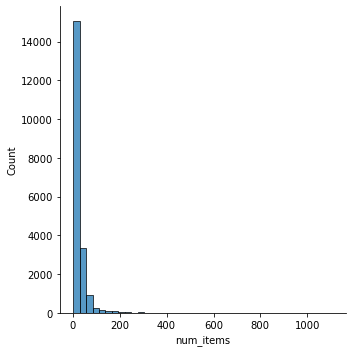

In [23]:
sns.displot(num_items["num_items"], bins=40)

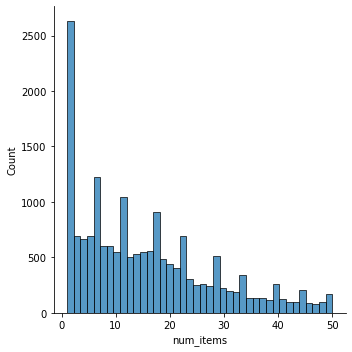

In [24]:
below_50 = num_items[num_items["num_items"] <= 50]
sns.displot(below_50["num_items"], bins=40)

In [25]:
distinct_query = '''
SELECT COUNT(DISTINCT(invoice)) "num_invoices", COUNT(DISTINCT(description)) "num_products"
FROM retail2
'''

run_query(distinct_query)

,num_invoices,num_products
0,20134,4077


In [26]:
conn.close()